In [72]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [73]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
from openpyxl import *
from datetime import timedelta
warnings.filterwarnings("ignore")

In [74]:
data = pd.read_csv('./data/Online_Sales.csv')
data.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [75]:
data = data.drop(["Product_SKU", "Product_Description", "Product_Category", "Delivery_Charges"], axis=1)
data["Amount"]=data["Avg_Price"]*data["Quantity"]
data = data.drop(["Quantity", "Avg_Price"], axis=1)

In [76]:
# Check for duplicate rows
if data['Transaction_ID'].duplicated().any():
    print("id duplicated")
    data = data.drop_duplicates(subset='Transaction_ID', keep='first')
else:
    print("id identical")

id duplicated


In [77]:
reference_date = pd.to_datetime("2020-01-01")
data['Transaction_Date'] = pd.to_datetime(data['Transaction_Date'])

# Step 1: RFMT
grouped = data.groupby('CustomerID').agg(
    join_date=('Transaction_Date', 'min'),
    last_purchase_date=('Transaction_Date', 'max'),
    frequency=('Transaction_ID', 'count'),
    monetary_value=('Amount', 'mean'),
    total_amount=('Amount', 'sum'),
    purchase_dates=('Transaction_Date', lambda x: sorted(x)),
    coupon_used=('Coupon_Status', lambda x: x.sum() if x.dtype == 'bool' else (x == 'True').sum())
).reset_index()

# Right formatting of data
grouped['frequency'] = grouped['frequency'].astype(int)
grouped['coupon_used'] = grouped['coupon_used'].astype(int)
grouped['join_date'] = pd.to_datetime(grouped['join_date'])
grouped['last_purchase_date'] = pd.to_datetime(grouped['last_purchase_date'])

# Step 2: Recency & T
grouped['recency'] = (reference_date - grouped['last_purchase_date']).dt.days
grouped['T'] = (reference_date - grouped['join_date']).dt.days

# Step 3: Purchase Cycle
def calculate_purchase_cycle(dates):
    if len(dates) <= 1:
        return 0
    date_diffs = [(dates[i] - dates[i-1]).days for i in range(1, len(dates))]
    return sum(date_diffs) / len(date_diffs)

grouped['purchase_cycle'] = grouped['purchase_dates'].apply(calculate_purchase_cycle)

grouped.head()

,CustomerID,join_date,last_purchase_date,frequency,monetary_value,total_amount,purchase_dates,coupon_used,recency,T,purchase_cycle
0,12346,2019-09-15,2019-09-15,1,19.990000,19.99,[2019-09-15 00:00:00],0,108,108,0.000000
1,12347,2019-03-24,2019-11-02,30,201.486000,6044.58,"[2019-03-24 00:00:00, 2019-03-24 00:00:00, 201...",0,60,283,7.689655
2,12348,2019-06-22,2019-10-19,7,76.492857,535.45,"[2019-06-22 00:00:00, 2019-06-22 00:00:00, 201...",0,74,193,19.833333
3,12350,2019-12-14,2019-12-14,11,99.538182,1094.92,"[2019-12-14 00:00:00, 2019-12-14 00:00:00, 201...",0,18,18,0.000000
4,12356,2019-09-15,2019-09-15,12,81.029167,972.35,"[2019-09-15 00:00:00, 2019-09-15 00:00:00, 201...",0,108,108,0.000000


In [78]:
# Train-test split
train_data = data[data['Transaction_Date'] < '2019-07-01']
test_data = data[data['Transaction_Date'] >= '2019-07-01']

summary_data_train = train_data.groupby('CustomerID').agg(
    join_date=('Transaction_Date', 'min'),
    last_purchase_date=('Transaction_Date', 'max'),
    frequency=('Transaction_ID', 'count'),
    monetary_value=('Amount', 'mean'),
    total_amount=('Amount', 'sum'),
    purchase_dates=('Transaction_Date', lambda x: sorted(x))
).reset_index()

summary_data_train['recency'] = (pd.to_datetime('2019-07-01') - summary_data_train['last_purchase_date']).dt.days
summary_data_train['T'] = (pd.to_datetime('2019-07-01') - summary_data_train['join_date']).dt.days
summary_data_train['purchase_cycle'] = summary_data_train['purchase_dates'].apply(calculate_purchase_cycle)


summary_data_test = test_data.groupby('CustomerID').agg(
    actual_3m_CLV=('Amount', 'sum')
).reset_index()


summary_data_train = summary_data_train.drop(columns=['purchase_dates'])


# print(summary_data_train.head())


In [79]:
final_data = pd.merge(
    summary_data_train,
    summary_data_test,
    on='CustomerID',
    how='left'
)
final_data['actual_3m_CLV'] = final_data['actual_3m_CLV'].fillna(0)
final_data.drop(['join_date','last_purchase_date'], axis=1, inplace=True)

final_data.head()

,CustomerID,frequency,monetary_value,total_amount,recency,T,purchase_cycle,actual_3m_CLV
0,12347,13,277.682308,3609.87,99,99,0.000000,2434.71
1,12348,3,11.870000,35.61,9,9,0.000000,499.84
2,12370,42,91.369524,3837.52,6,36,0.731707,0.00
3,12386,3,93.863333,281.59,96,96,0.000000,45.94
4,12395,11,71.594545,787.54,3,142,13.900000,79.00


In [80]:
# Separate customers into train-test sets
Customer_train, Customer_test = train_test_split(final_data, test_size=0.2, random_state=42)
Customer_train.head()
print(Customer_train.dtypes)


CustomerID          int64
frequency           int64
monetary_value    float64
total_amount      float64
recency             int64
T                   int64
purchase_cycle    float64
actual_3m_CLV     float64
dtype: object


In [81]:
features = ['recency', 'frequency', 'monetary_value', 'T', 'purchase_cycle']

X = Customer_train[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(Customer_test[features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=Customer_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=Customer_test.index)
X_train_scaled.head()

,recency,frequency,monetary_value,T,purchase_cycle
331,-0.725872,0.052874,0.259370,-1.143458,-0.272806
362,-0.067794,-0.312352,-0.470225,-0.480339,-0.272806
698,1.944044,-0.468878,-0.006212,1.546912,-0.272806
774,-0.161805,-0.260177,-0.000573,-0.575070,-0.272806
306,0.797108,0.105049,-0.697413,0.391190,-0.272806


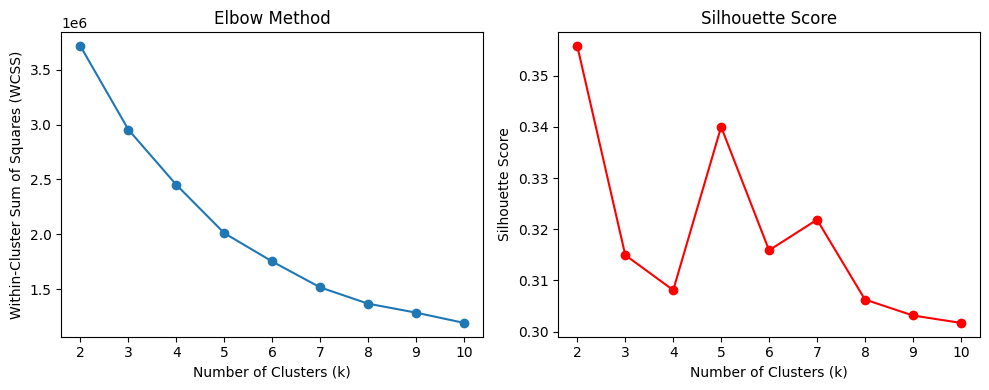

In [82]:
# Elbow Method: WCSS for different k values
wcss = []
silhouette_scores = []
K_range = range(2, 11)  # Testing k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    wcss.append(kmeans.inertia_)  # WCSS
    silhouette_scores.append(silhouette_score(X, labels))  # Silhouette Score

# Plot Elbow Method
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method")

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.tight_layout()
plt.show()

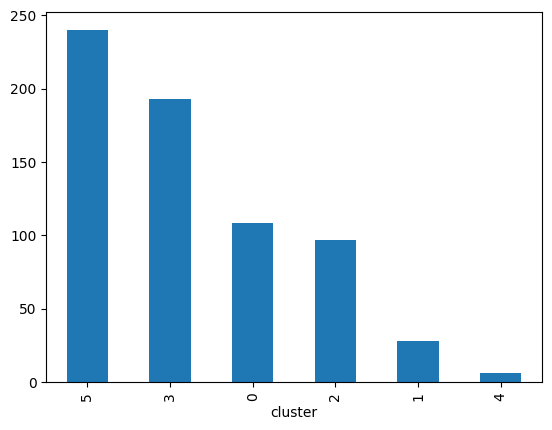

In [88]:
kmeans = KMeans(n_clusters=6, random_state=42)
Customer_train['cluster'] = kmeans.fit_predict(X_train_scaled)

Customer_train['cluster'].value_counts().plot(kind='bar')
plt.show()

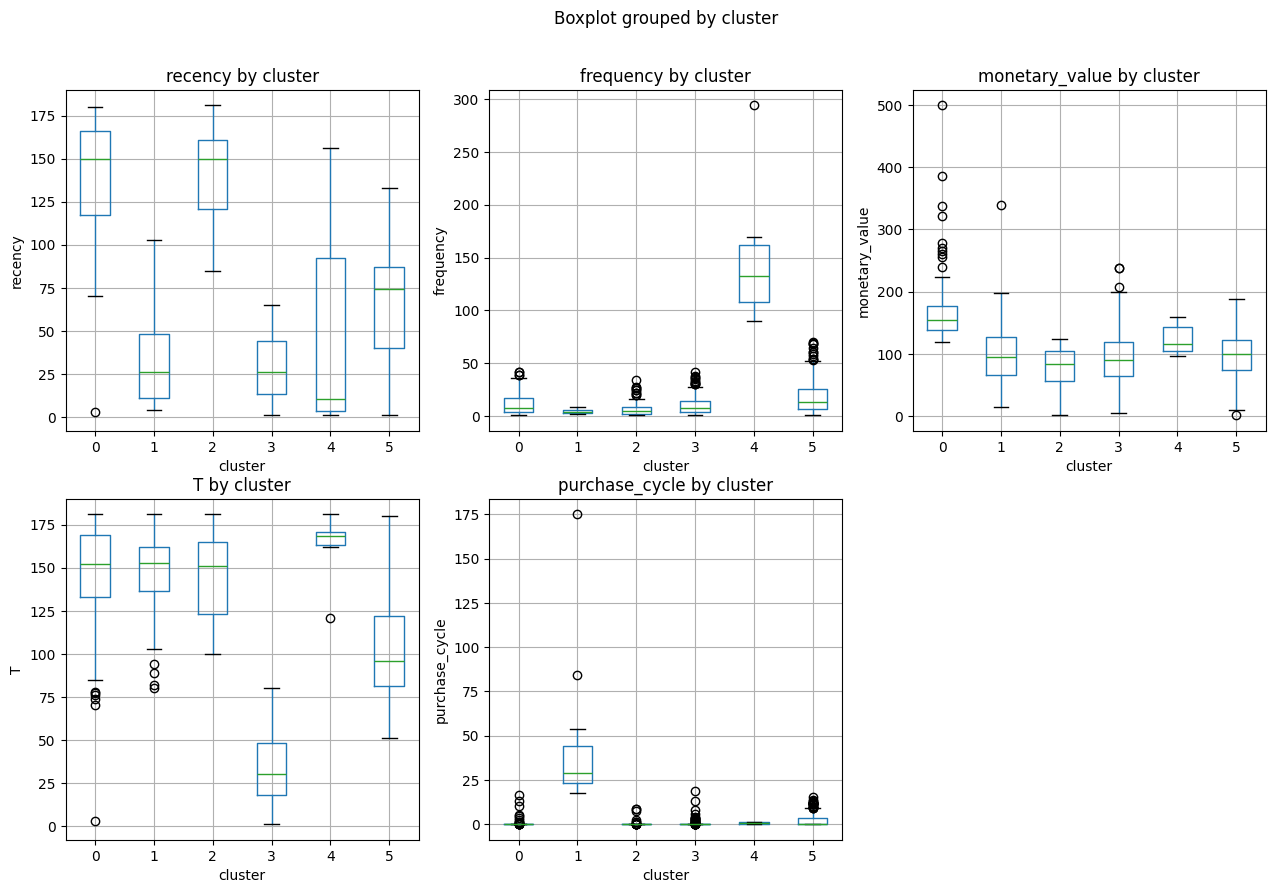

In [89]:
# Visualisation of customer segments distribution
features = Customer_train[['recency', 'frequency', 'monetary_value', 'T', 'purchase_cycle']]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Distributuion of Features by Cluster')
axes = axes.flatten()

for i, feature in enumerate(features):
    Customer_train.boxplot(column=feature, by='cluster', ax=axes[i])
    axes[i].set_title(f'{feature} by cluster')
    axes[i].set_xlabel('cluster')
    axes[i].set_ylabel(feature)

# Hide the unused subplot (the last one)
axes[-1].axis('off')

plt.show()

In [90]:
cluster_means = Customer_train.groupby('cluster')['actual_3m_CLV'].mean().to_dict()

Customer_test['cluster'] = kmeans.predict(X_test_scaled)
Customer_test['pred_3m_CLV'] = Customer_test['cluster'].map(cluster_means)

mae = mean_absolute_error(Customer_test['actual_3m_CLV'], Customer_test['pred_3m_CLV'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

r2 = r2_score(Customer_test['actual_3m_CLV'], Customer_test['pred_3m_CLV'])
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 1068.26
R² Score: 0.0286


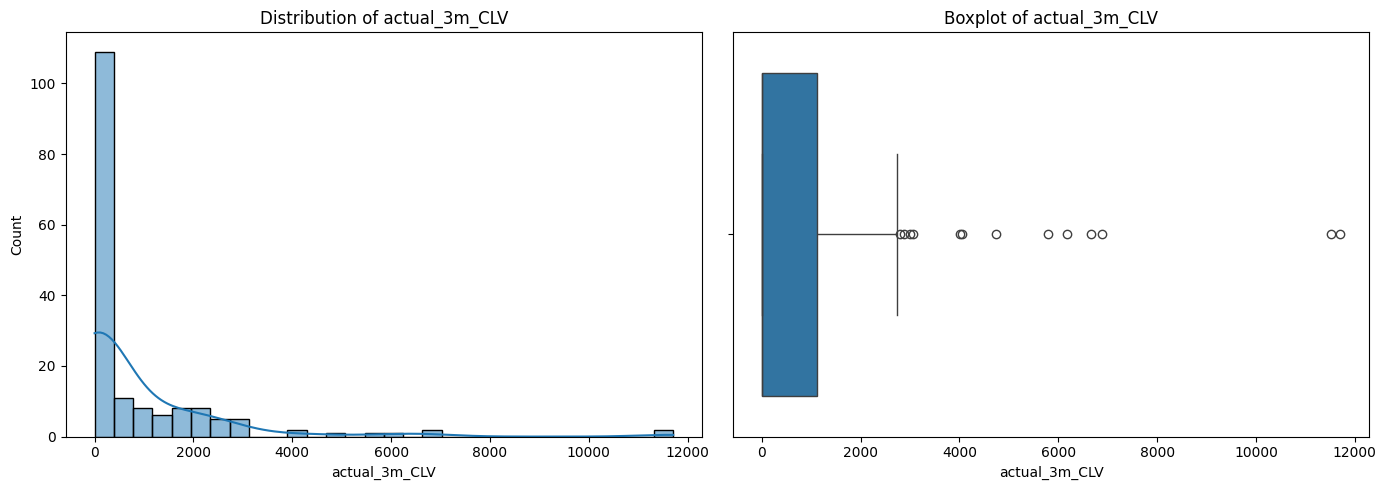

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(Customer_test['actual_3m_CLV'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of actual_3m_CLV')
axes[0].set_xlabel('actual_3m_CLV')
axes[0].set_ylabel('Count')

sns.boxplot(x=Customer_test['actual_3m_CLV'], ax=axes[1])
axes[1].set_title('Boxplot of actual_3m_CLV')

plt.tight_layout()
plt.show()